In [23]:
import pandas as pd

synthetic_df = pd.read_csv('synthetic_data.csv')
original_df = pd.read_csv('WEB_TARGET.csv')

### Multiclass Classification of 6 month occlusion '6_mo_occ'

In [24]:
original_df.columns

Index(['Age', 'Sex', 'Ruptured', 'Circulation', 'Location', 'Ignore',
       'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
       'Other diameter', 'Neck (mm) orthogonal view 1',
       'Neck (mm) orthogonal view 2', 'Avg neck vol', 'Aneurysm 3D Volume',
       'WEB_1_Name', 'SL/Elongated', 'WEB_1_width', 'WEB_1_Height',
       'WEB Volume', 'WEB Device #2 name', 'WEB 2 Volume', 'Final WEB Volume',
       'Comments on why a second device needed',
       'Complete WEB failure/abandonment', 'Re-sizing required',
       'Stenting used to support WEB?', 'Composite outcome',
       'Procedure related ischemic stroke?', 'Intraop rupture', '3_mo_occ',
       '6_mo_occ', '1_year_occ', 'Dual_length'],
      dtype='object')

In [25]:
synthetic_df.shape

(1000, 20)

In [26]:
synthetic_df.dtypes

Age                                   float64
Sex                                     int64
Ruptured                                int64
Circulation                             int64
Max diameter in any dimension (mm)    float64
Height (mm)                           float64
Width (mm)                            float64
Neck (mm) orthogonal view 1           float64
Neck (mm) orthogonal view 2           float64
Avg neck vol                          float64
Aneurysm 3D Volume                    float64
SL/Elongated                            int64
Final WEB Volume                      float64
Complete WEB failure/abandonment        int64
Re-sizing required                      int64
Stenting used to support WEB?           int64
Composite outcome                       int64
Procedure related ischemic stroke?      int64
Intraop rupture                         int64
6_mo_occ                                int64
dtype: object


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[10:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Training Random Forest...
Training XGBoost...


[10:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



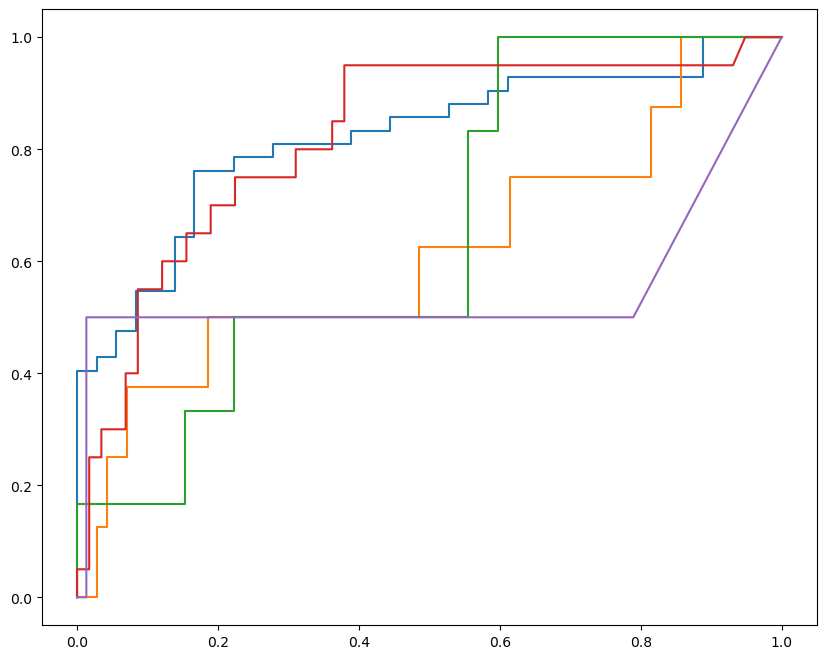

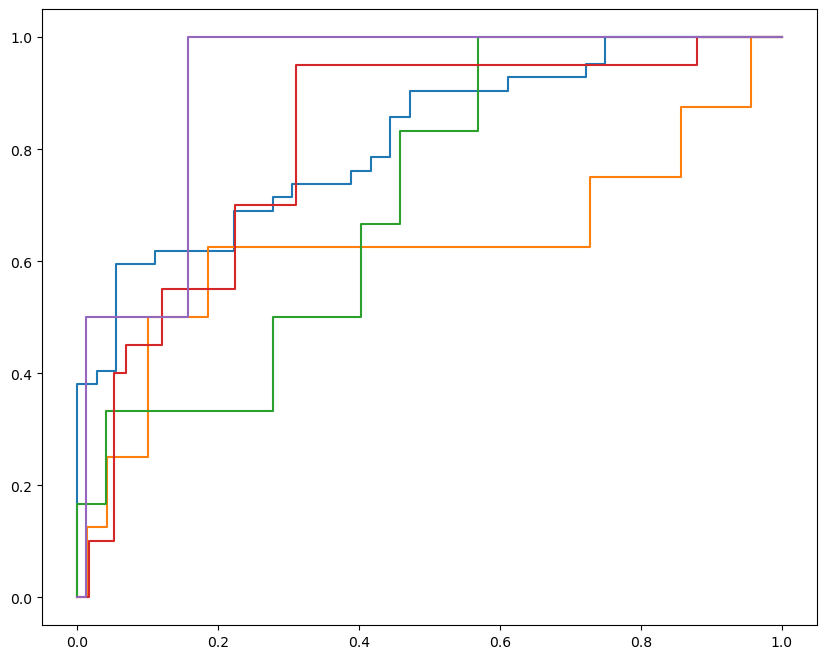

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Define features and target
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

# Use the entire synthetic dataset
X = synthetic_df[features]
y = synthetic_df[target]

# Prepare original dataset for testing
X_test = original_df[features]
y_test = original_df[target]

# Fill missing values in test data
X_test.fillna(X_test.mean(), inplace=True)

# Define parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_rf.fit(X, y)
best_rf = grid_search_rf.best_estimator_

# Perform grid search for XGBoost
grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
    param_grid_xgb, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_xgb.fit(X, y)
best_xgb = grid_search_xgb.best_estimator_

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train models with best hyperparameters
models = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X, y)  # Train on the entire synthetic dataset
    
    # Performance on original dataset
    y_test_proba = model.predict_proba(X_test)
    
    # Calculate AUC per class and plot ROC curves
    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y_test):
        # Binary target for the current class
        y_test_binary = (y_test == class_label).astype(int)
        
        # Get false positive rate, true positive rate, and thresholds
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc
        
        # Plot ROC curve for the current class
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    


In [28]:
import shap

# Initialize SHAP visualizations
shap.initjs()

# Use the XGBoost model directly
xgb_classifier = models['Random Forest']  # Use the trained XGBoost model

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_classifier)

# Compute SHAP values for the test set
shap_values_original = explainer.shap_values(X_test)  # Original test data

# Visualize SHAP force plot for an individual prediction (local interpretation)
sample_index = 0  # Index of the sample to explain
shap.force_plot(
    explainer.expected_value[0],  # Expected value for class 0
    shap_values_original[0][sample_index, :],  # SHAP values for class 0
    X_test.iloc[sample_index, :],  # Input data for the sample
    feature_names=features
)


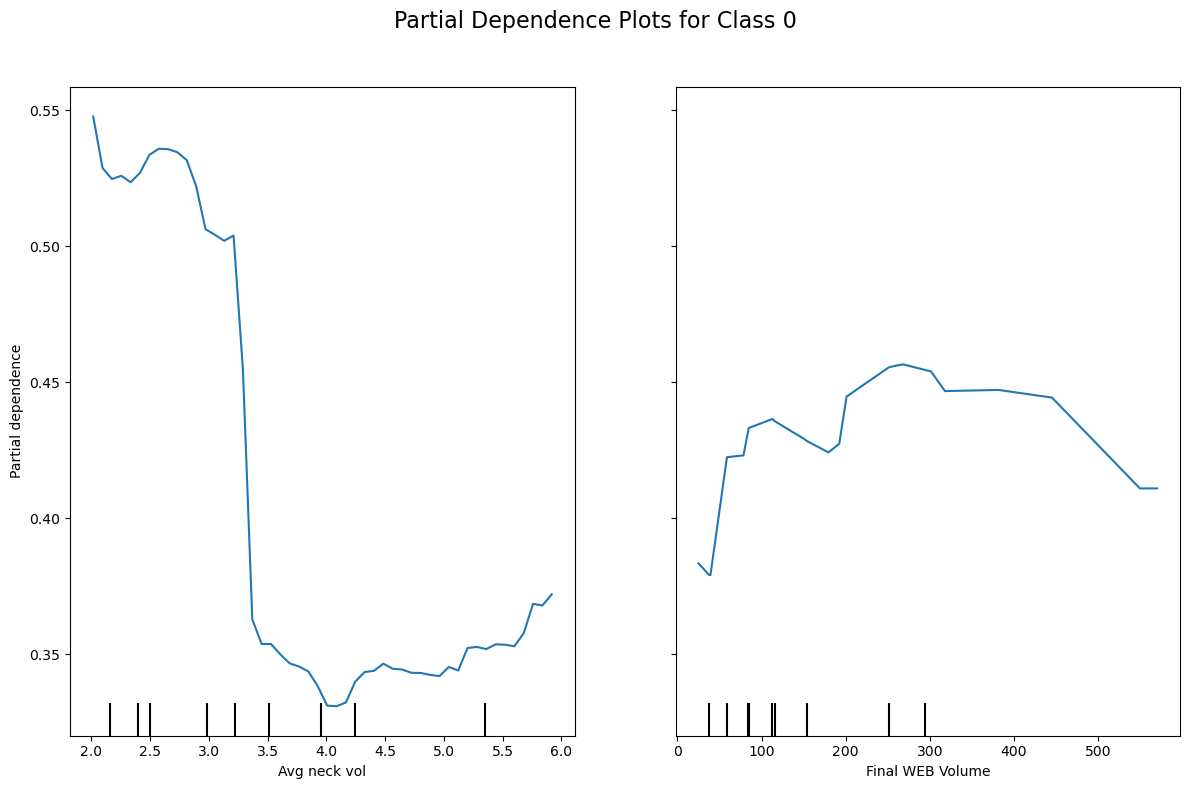

In [29]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use Random Forest model (already trained)
model = models['Random Forest']

# Define features for PDPs
pdp_features = ['Avg neck vol', 'Final WEB Volume']

# Specify the target class (e.g., 0 for the first class)
target_class = 0

# Generate Partial Dependence Plots for the specified target class
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    model,
    X_test,  # Test data
    pdp_features,
    target=target_class,  # Specify the target class
    grid_resolution=50,  # Number of intervals to evaluate
    ax=ax
)

# Adjust plot appearance
plt.suptitle(f"Partial Dependence Plots for Class {target_class}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


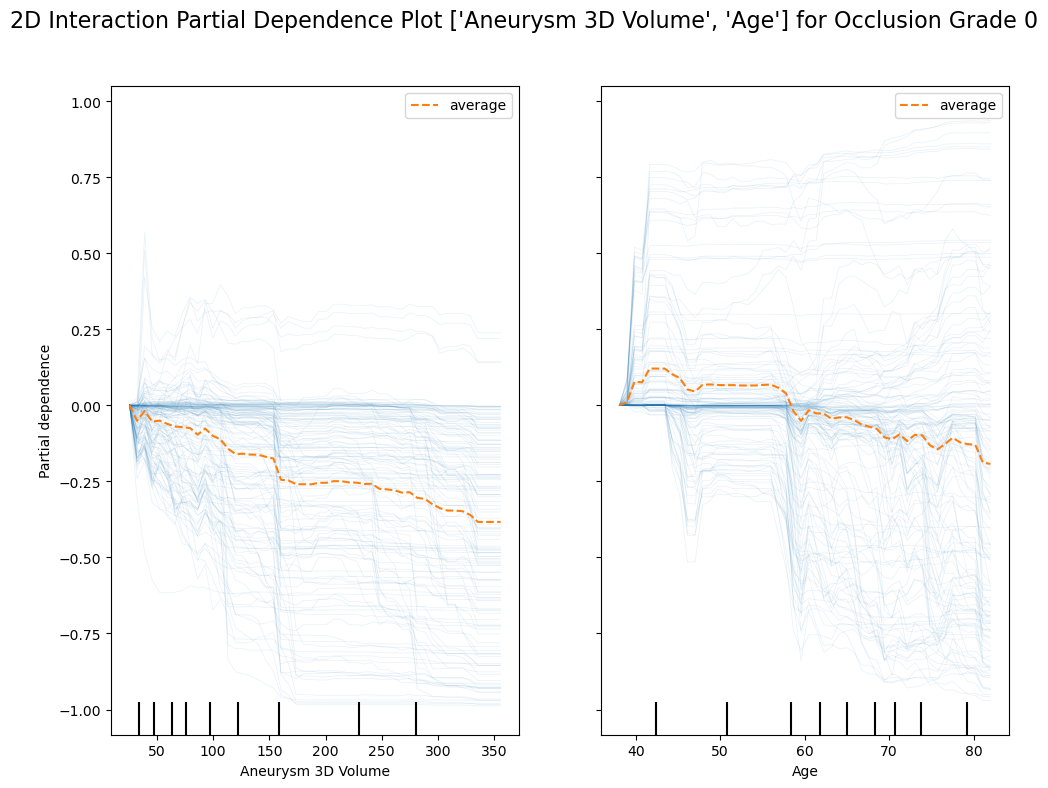

In [30]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Use Random Forest model (already trained)
model = models['XGBoost']  # Replace with the desired model

# Define the two features to study the interaction
interaction_features = ['Aneurysm 3D Volume', 'Age']

# Specify the target class (e.g., 0 for the first class)
target_class = 0

# Define parameters for the ICE plot
n_samples = 150  # Number of curves to plot (sampling)
alpha = 0.1  # Transparency for ICE lines

# Generate 2D interaction Partial Dependence Plot (with c-ICE)
fig, ax = plt.subplots(figsize=(10, 8))
display = PartialDependenceDisplay.from_estimator(
    model,
    X,  # Test data
    interaction_features,  # Features for interaction
    target=target_class,  # Specify target class
    kind="both",  # Show contour and 3D surfaces
    grid_resolution=50,  # Higher resolution for smoother plots
    ice_lines_kw={'alpha': alpha},  # Add transparency to ICE lines
    centered=True,  # Enable centered ICE plots
    n_jobs=-1,  # Use all cores for computation
    subsample=n_samples,  # Subsample ICE curves for better visibility
    ax=ax
)

# Customize plot
plt.suptitle(f"2D Interaction Partial Dependence Plot {interaction_features} for Occlusion Grade {target_class}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


H-statistic (Interaction Strength) between ['Aneurysm 3D Volume', 'Final WEB Volume']: 0.0580


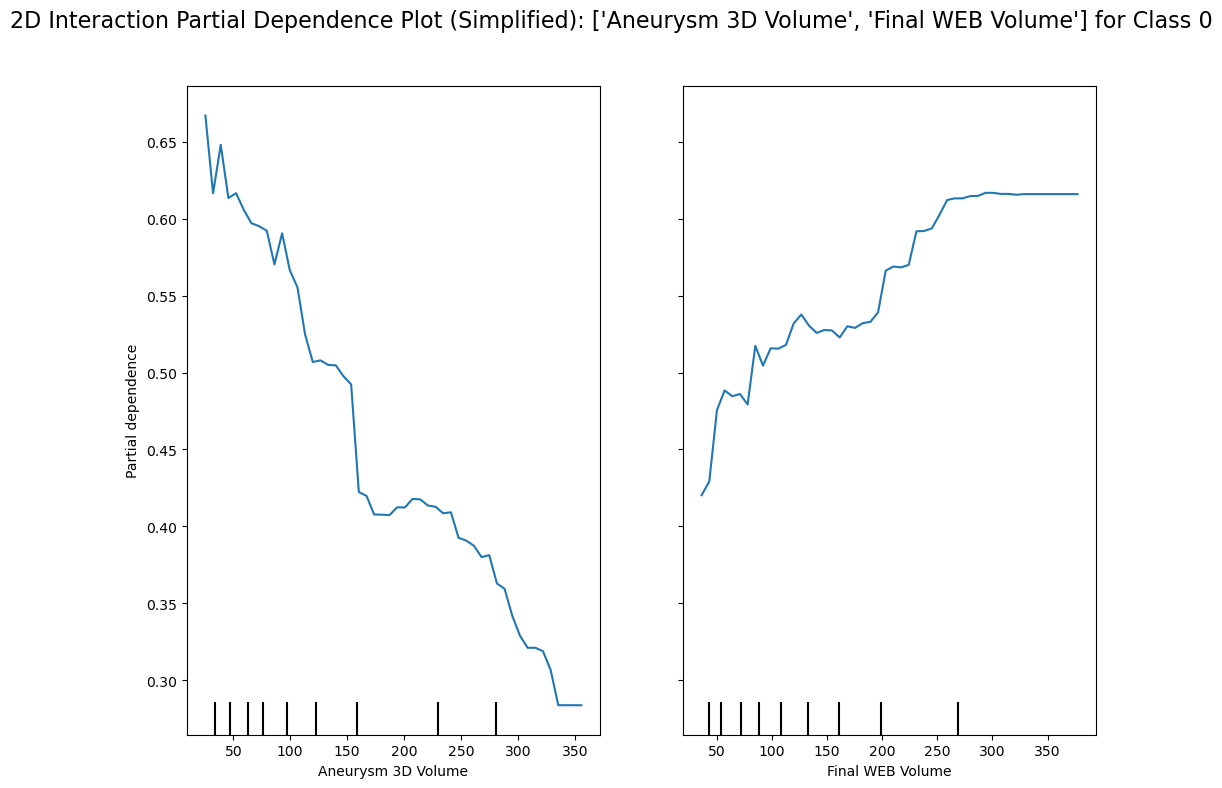

In [31]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define the two features to study the interaction
interaction_features = ['Aneurysm 3D Volume', 'Final WEB Volume']

# Specify the target class (e.g., 0 for the first class)
target_class = 0

# Calculate 2D Partial Dependence
pdp_result = partial_dependence(
    model,
    X,  # Synthetic data
    features=interaction_features,
    grid_resolution=50
)

# Extract Partial Dependence Values
pdp_values = pdp_result.average  # Average over all samples
feature_values = pdp_result.values  # Feature grid values

# Calculate the H-statistic
pdp_interaction = pdp_values
pdp_1 = np.mean(pdp_interaction, axis=1, keepdims=True)
pdp_2 = np.mean(pdp_interaction, axis=0, keepdims=True)
pdp_no_interaction = pdp_1 + pdp_2 - np.mean(pdp_interaction)
interaction_strength = np.sum((pdp_interaction - pdp_no_interaction) ** 2) / np.sum(pdp_interaction ** 2)
print(f"H-statistic (Interaction Strength) between {interaction_features}: {interaction_strength:.4f}")

# Simplified ICE Plot
fig, ax = plt.subplots(figsize=(10, 8))
PartialDependenceDisplay.from_estimator(
    model,
    X,
    interaction_features,
    target=target_class,
    kind="average",  # Aggregate ICE into major regions (average curve)
    grid_resolution=50,
    ax=ax
)

# Customize plot
plt.suptitle(f"2D Interaction Partial Dependence Plot (Simplified): {interaction_features} for Class {target_class}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



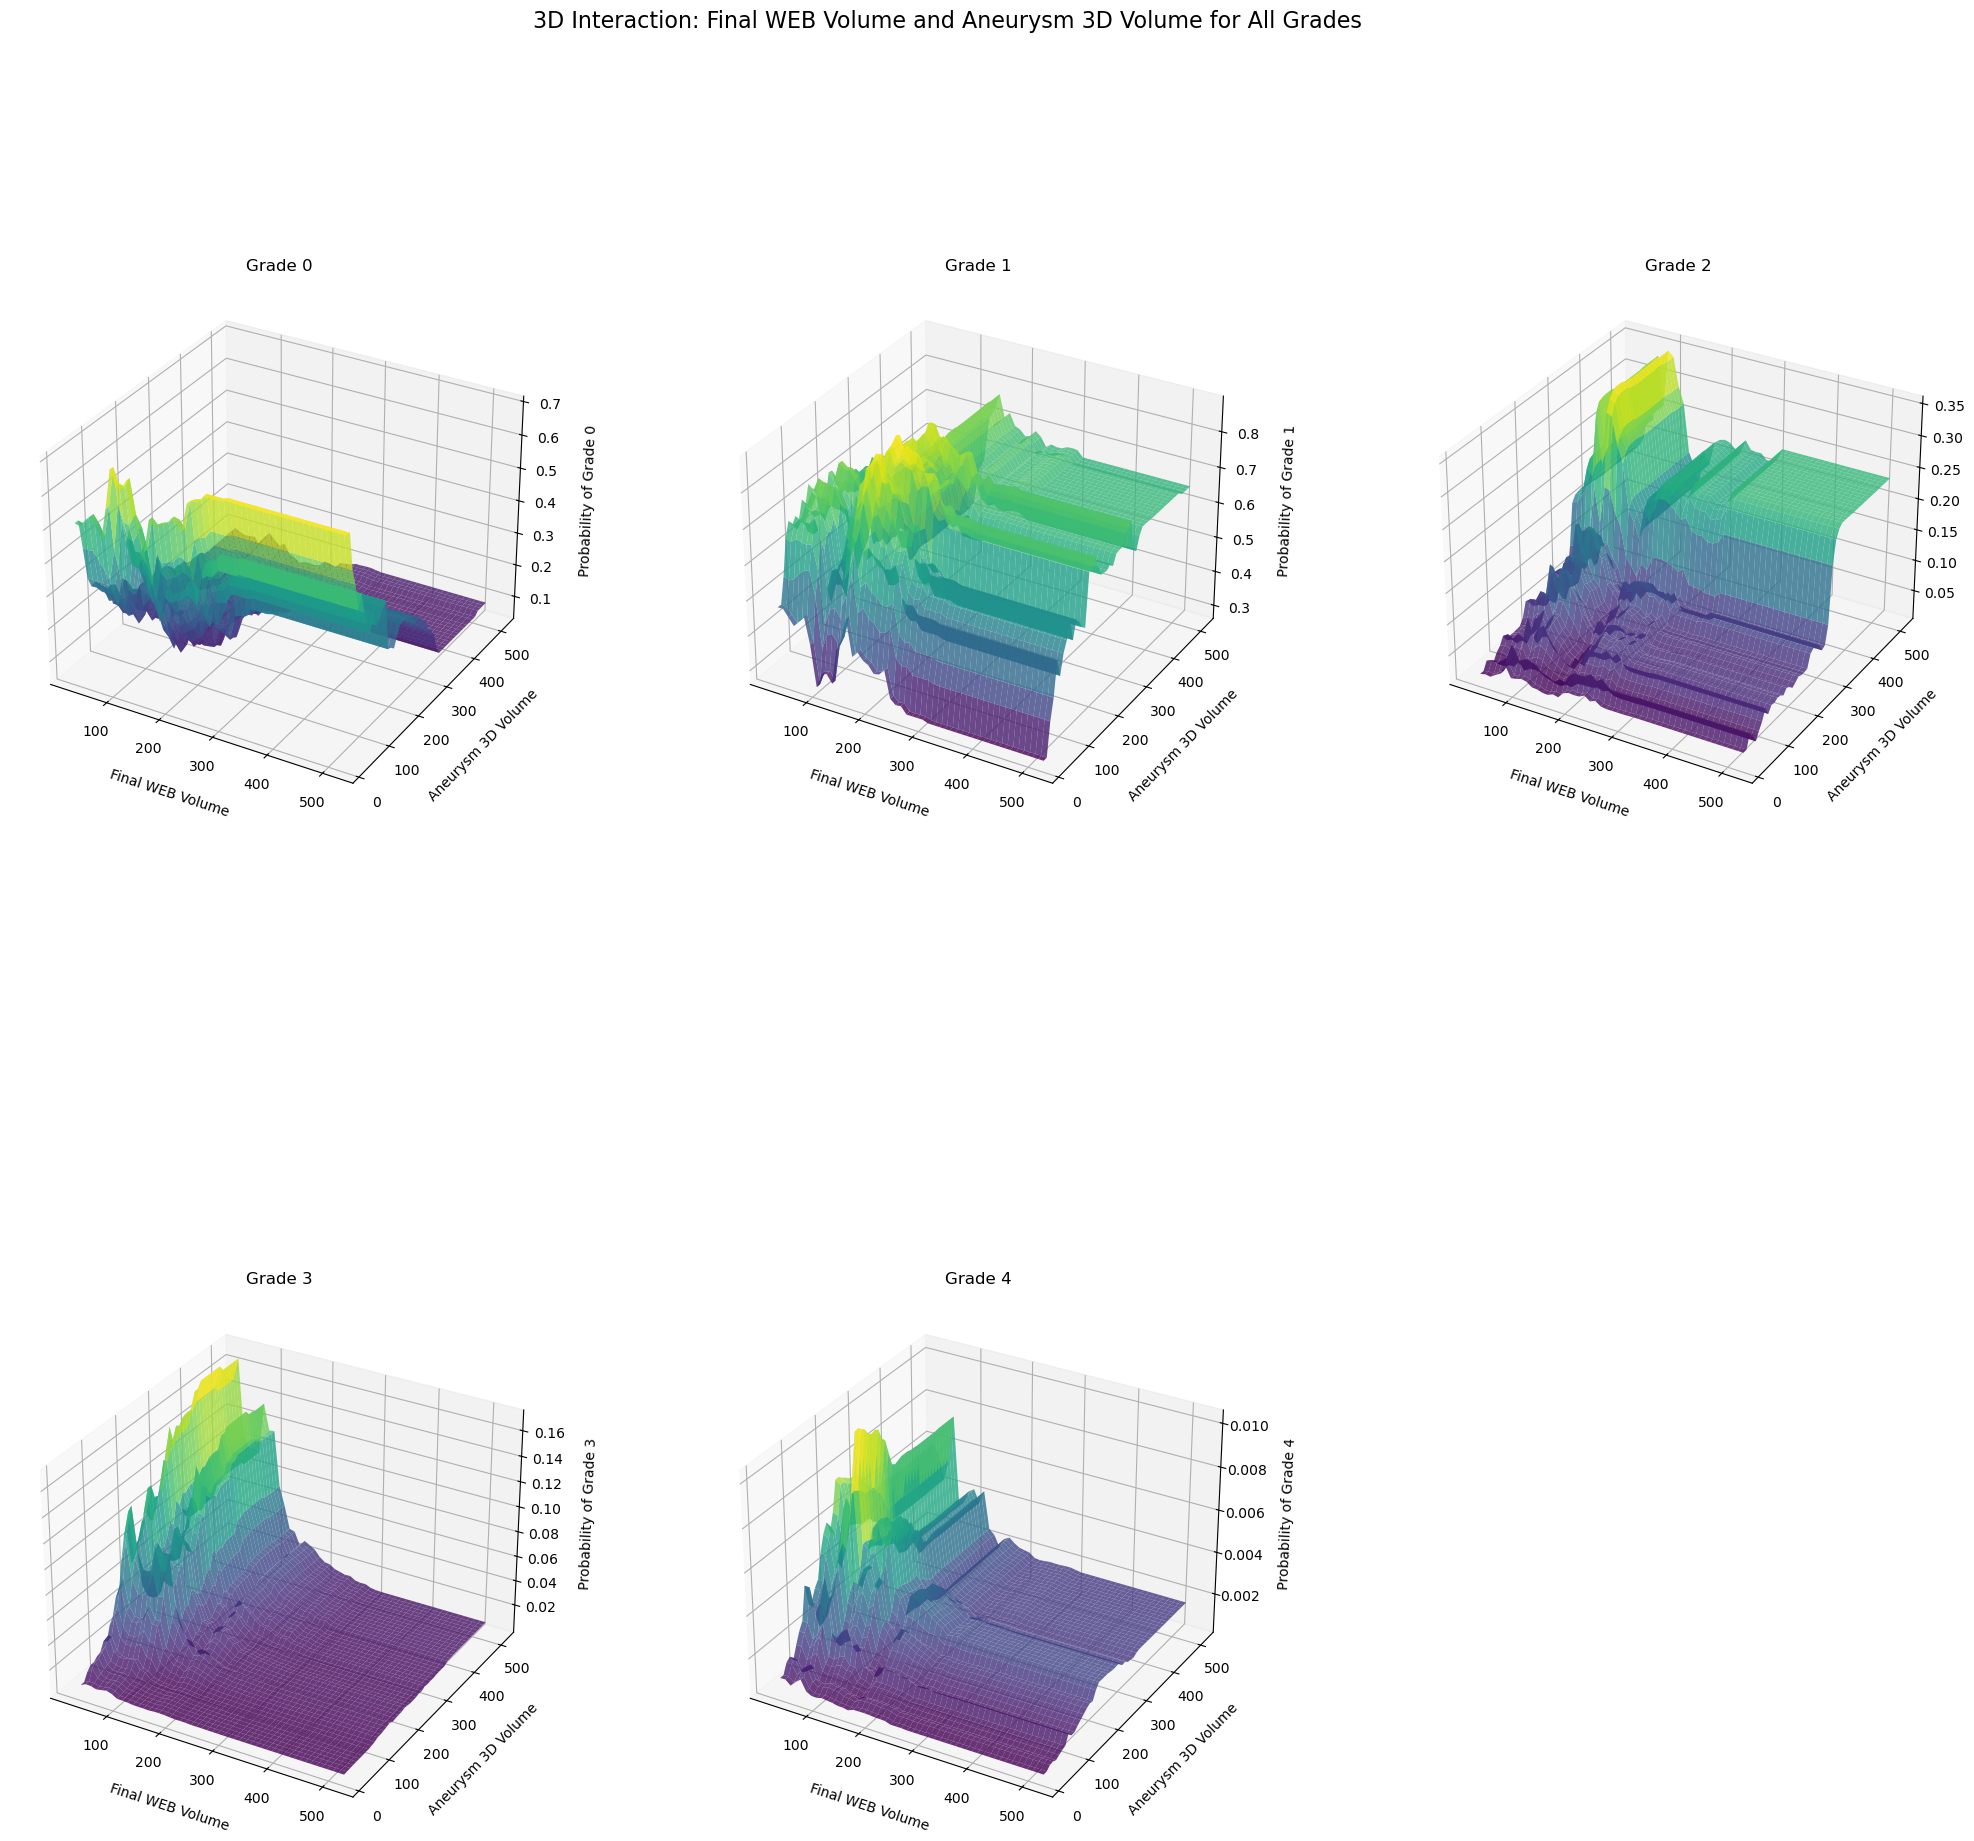

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a grid of WEB Volume and Aneurysm 3D Volume
web_volume_range = np.linspace(X["Final WEB Volume"].min(), X["Final WEB Volume"].max(), 50)
aneurysm_volume_range = np.linspace(X["Aneurysm 3D Volume"].min(), X["Aneurysm 3D Volume"].max(), 50)
web_volume, aneurysm_volume = np.meshgrid(web_volume_range, aneurysm_volume_range)

# Create a feature matrix for prediction
grid_data = np.zeros((web_volume.size, X.shape[1]))
grid_data[:, features.index("Final WEB Volume")] = web_volume.ravel()
grid_data[:, features.index("Aneurysm 3D Volume")] = aneurysm_volume.ravel()

# Fill remaining features with their mean values
for feature_idx in range(X.shape[1]):
    if feature_idx not in [features.index("Final WEB Volume"), features.index("Aneurysm 3D Volume")]:
        grid_data[:, feature_idx] = X.iloc[:, feature_idx].mean()

# Convert grid_data to a DataFrame with appropriate feature names
grid_data_df = pd.DataFrame(grid_data, columns=features)

# Loop through all classes and plot in one figure
model = models['XGBoost']  # Ensure you're using the appropriate model
n_classes = len(np.unique(y))  # Number of classes in the target variable

fig = plt.figure(figsize=(25, 22))

for class_idx in range(n_classes):
    # Predict probabilities for the current class
    probs = model.predict_proba(grid_data_df)[:, class_idx]  # Probabilities for the current class
    probs = probs.reshape(web_volume.shape)

    # Add subplot for each class
    ax = fig.add_subplot(2, (n_classes + 1) // 2, class_idx + 1, projection='3d')
    surf = ax.plot_surface(web_volume, aneurysm_volume, probs, cmap="viridis", alpha=0.8)

    # Add axis labels and titles
    ax.set_xlabel("Final WEB Volume", labelpad=10)
    ax.set_ylabel("Aneurysm 3D Volume", labelpad=10)
    ax.set_zlabel(f"Probability of Grade {class_idx}", labelpad=10)
    ax.set_title(f"Grade {class_idx}", fontsize=12)

# Adjust layout and spacing
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle("3D Interaction: Final WEB Volume and Aneurysm 3D Volume for All Grades", fontsize=16)
plt.show()


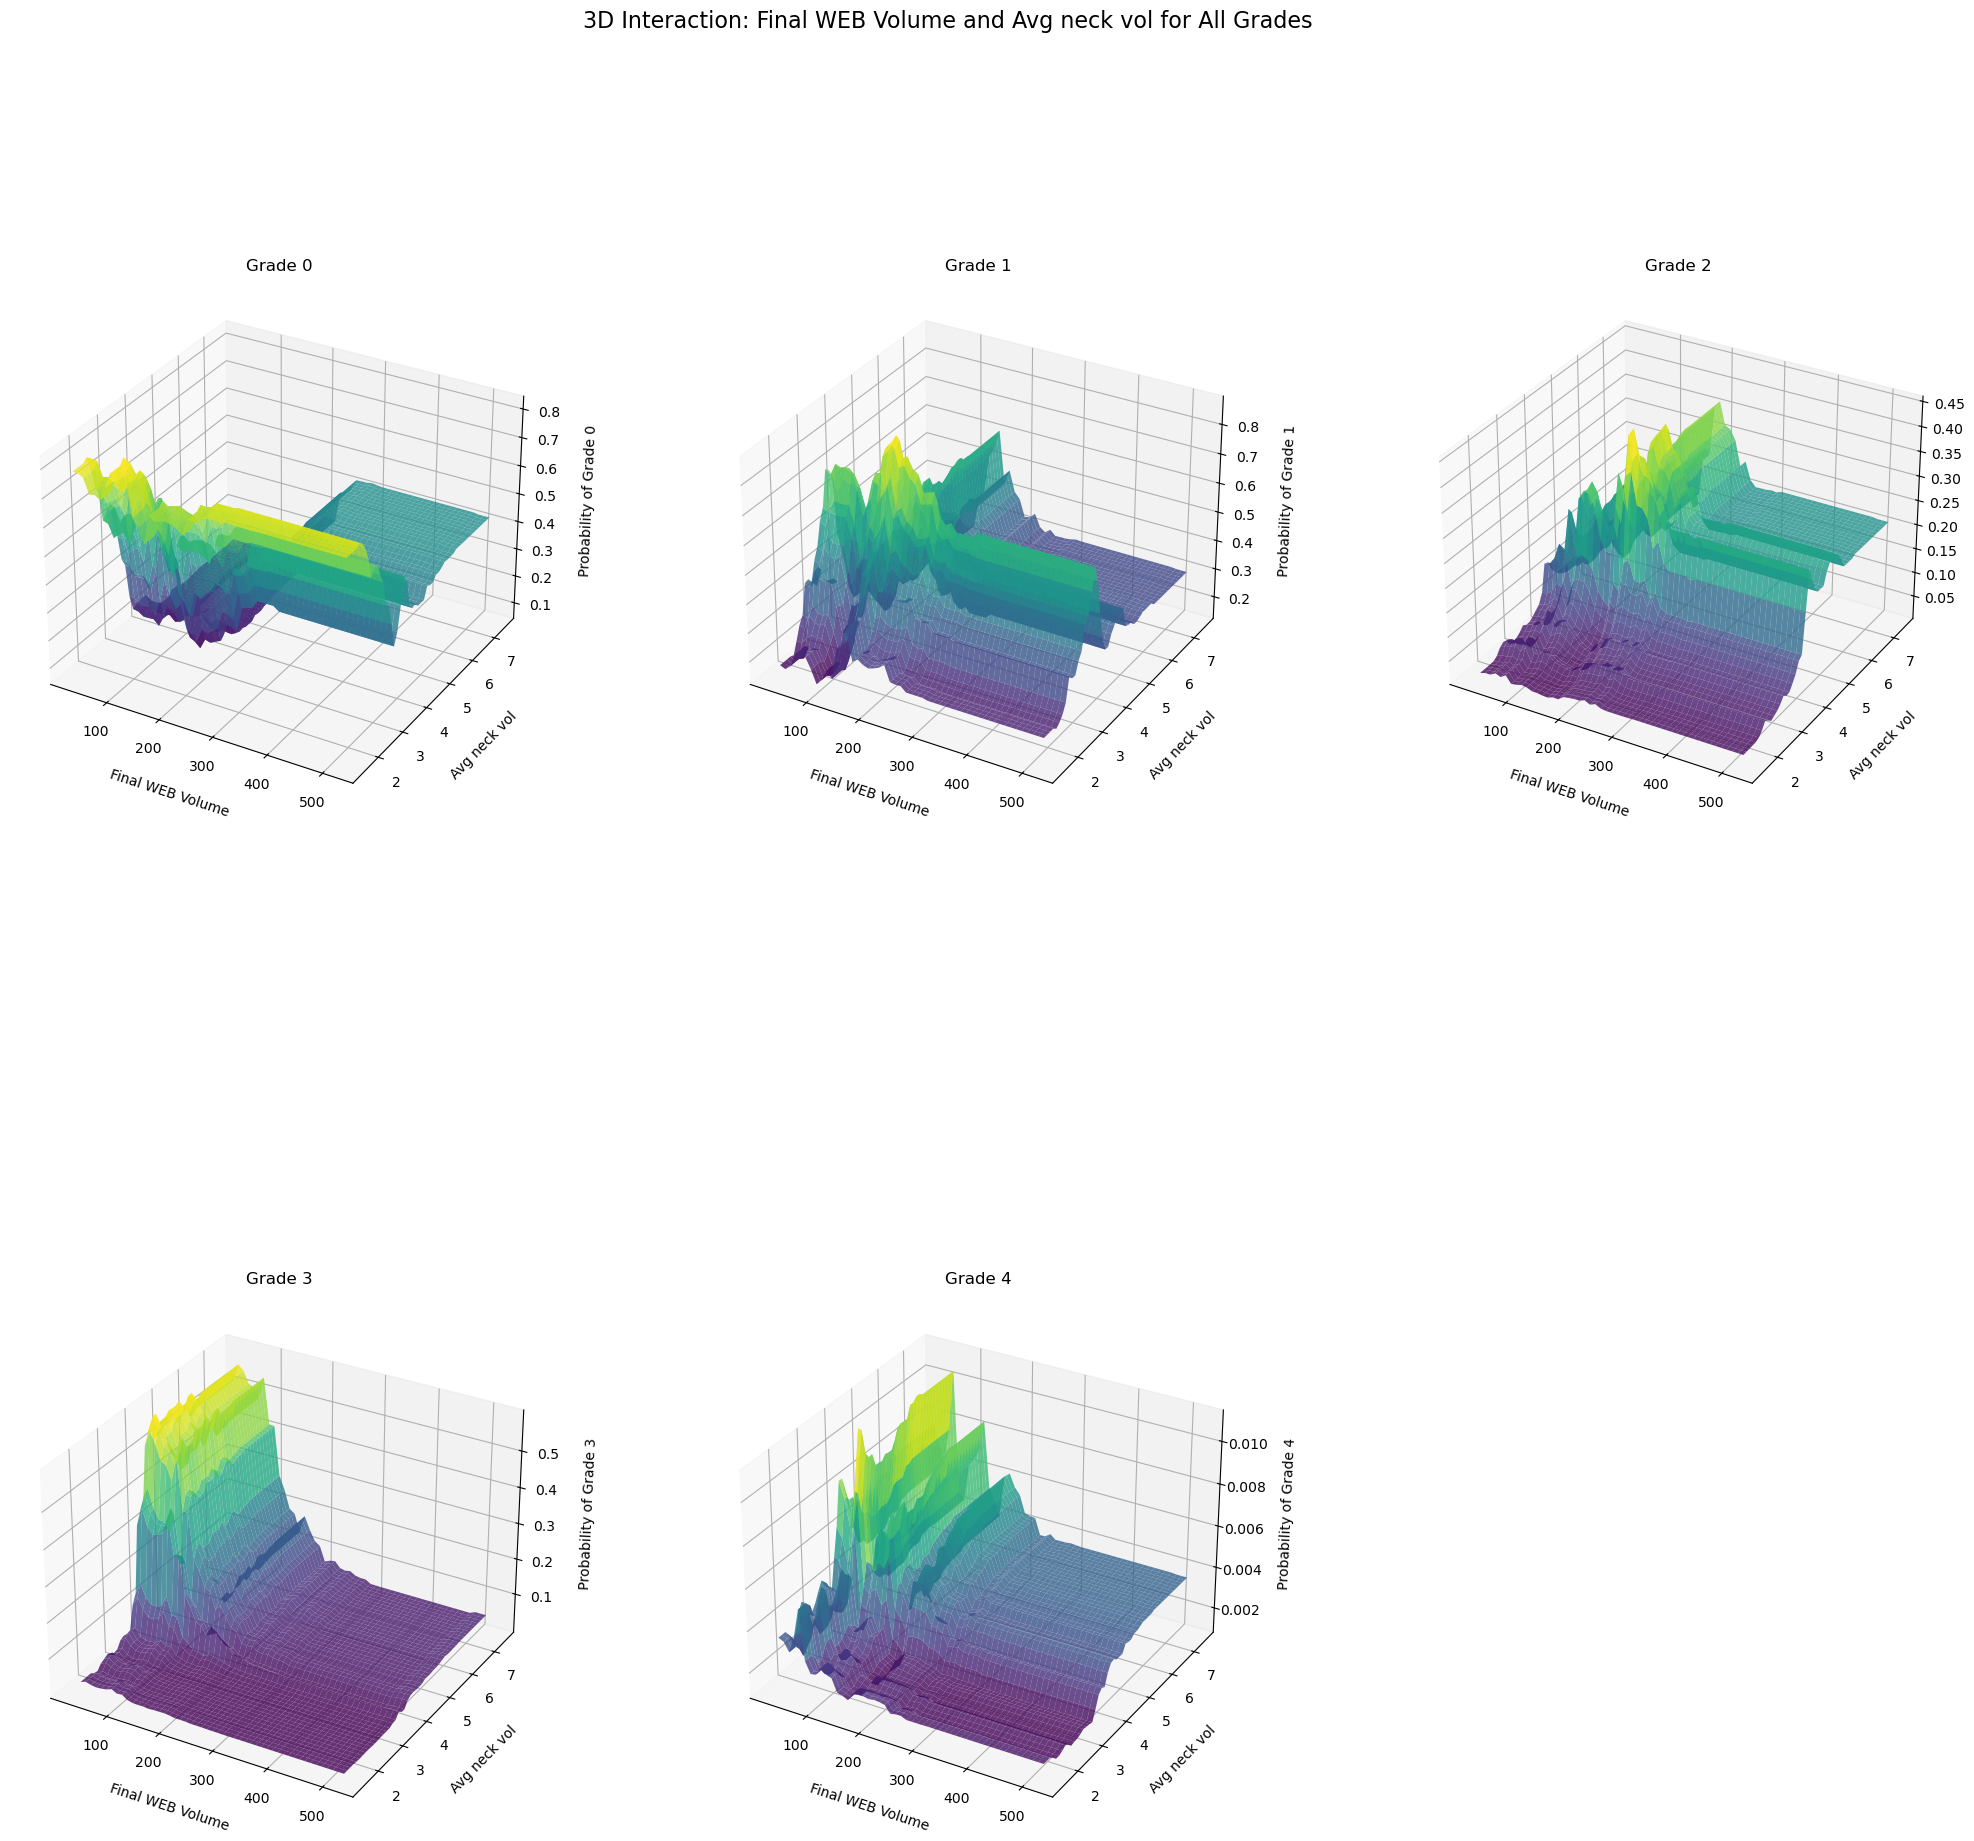

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a grid of WEB Volume and Avg neck vol
web_volume_range = np.linspace(X["Final WEB Volume"].min(), X["Final WEB Volume"].max(), 50)
aneurysm_volume_range = np.linspace(X["Avg neck vol"].min(), X["Avg neck vol"].max(), 50)
web_volume, aneurysm_volume = np.meshgrid(web_volume_range, aneurysm_volume_range)

# Create a feature matrix for prediction
grid_data = np.zeros((web_volume.size, X.shape[1]))
grid_data[:, features.index("Final WEB Volume")] = web_volume.ravel()
grid_data[:, features.index("Avg neck vol")] = aneurysm_volume.ravel()

# Fill remaining features with their mean values
for feature_idx in range(X.shape[1]):
    if feature_idx not in [features.index("Final WEB Volume"), features.index("Avg neck vol")]:
        grid_data[:, feature_idx] = X.iloc[:, feature_idx].mean()

# Convert grid_data to a DataFrame with appropriate feature names
grid_data_df = pd.DataFrame(grid_data, columns=features)

# Loop through all classes and plot in one figure
model = models['XGBoost']  # Ensure you're using the appropriate model
n_classes = len(np.unique(y))  # Number of classes in the target variable

fig = plt.figure(figsize=(25, 22))

for class_idx in range(n_classes):
    # Predict probabilities for the current class
    probs = model.predict_proba(grid_data_df)[:, class_idx]  # Probabilities for the current class
    probs = probs.reshape(web_volume.shape)

    # Add subplot for each class
    ax = fig.add_subplot(2, (n_classes + 1) // 2, class_idx + 1, projection='3d')
    surf = ax.plot_surface(web_volume, aneurysm_volume, probs, cmap="viridis", alpha=0.8)

    # Add axis labels and titles
    ax.set_xlabel("Final WEB Volume", labelpad=10)
    ax.set_ylabel("Avg neck vol", labelpad=10)
    ax.set_zlabel(f"Probability of Grade {class_idx}", labelpad=10)
    ax.set_title(f"Grade {class_idx}", fontsize=12)

# Adjust layout and spacing
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle("3D Interaction: Final WEB Volume and Avg neck vol for All Grades", fontsize=16)
plt.show()


In [34]:
features

['Age',
 'Sex',
 'Ruptured',
 'Circulation',
 'Max diameter in any dimension (mm)',
 'Height (mm)',
 'Width (mm)',
 'Neck (mm) orthogonal view 1',
 'Neck (mm) orthogonal view 2',
 'Avg neck vol',
 'Aneurysm 3D Volume',
 'SL/Elongated',
 'Final WEB Volume',
 'Complete WEB failure/abandonment',
 'Re-sizing required',
 'Stenting used to support WEB?',
 'Composite outcome',
 'Procedure related ischemic stroke?',
 'Intraop rupture']

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


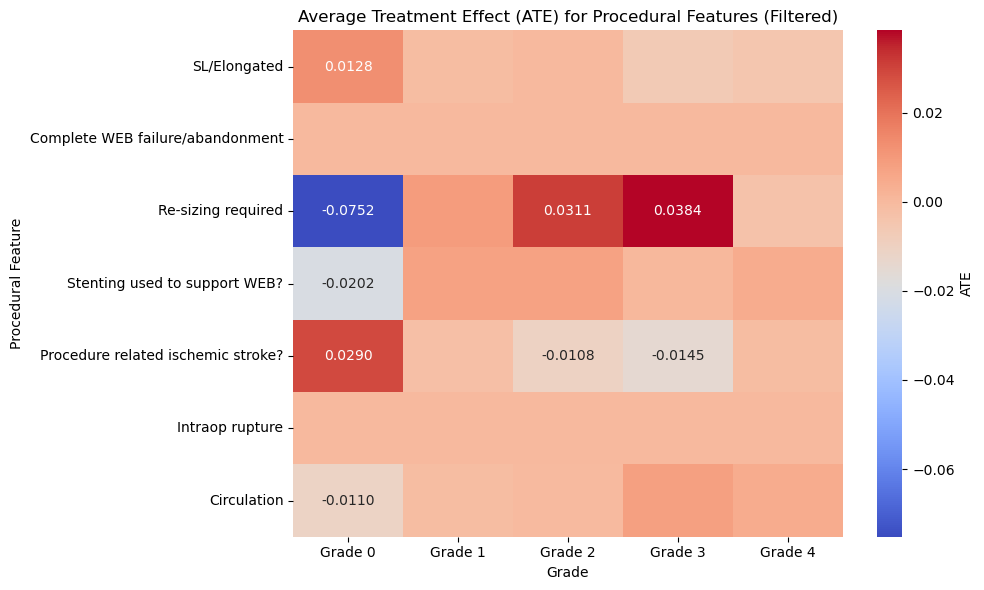

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define procedural features
procedural_features = [
    'SL/Elongated', 'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Procedure related ischemic stroke?', 'Intraop rupture', 'Circulation'
]

model = models['Random Forest']  # Use the trained model

# Calculate Average Treatment Effect (ATE) for each feature
ate_results = {}
for feature in procedural_features:
    ate_per_class = []
    for target_class in np.unique(y):  # Iterate over each class
        # Baseline predictions without intervention
        baseline_preds = model.predict_proba(X)[:, target_class]
        
        # Counterfactual data where the current feature is set to 1
        X_counterfactual = X.copy()
        X_counterfactual[feature] = 1
        
        # Counterfactual predictions
        counterfactual_preds = model.predict_proba(X_counterfactual)[:, target_class]
        
        # Calculate ATE for the current class and feature
        ate = np.mean(counterfactual_preds - baseline_preds)
        ate_per_class.append(ate)
    
    # Store ATE for this feature
    ate_results[feature] = ate_per_class

# Convert results to DataFrame for visualization
ate_df = pd.DataFrame(ate_results, index=[f'Grade {cls}' for cls in np.unique(y)]).T

# Prepare annotation DataFrame (only show values with abs(ATE) >= 0.01)
annot_df = ate_df.copy()
annot_df = annot_df.applymap(lambda x: f"{x:.4f}" if abs(x) >= 0.01 else "")

# Plot the ATE heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ate_df, annot=annot_df, cmap="coolwarm", fmt="", cbar_kws={'label': 'ATE'})
plt.title('Average Treatment Effect (ATE) for Procedural Features (Filtered)')
plt.xlabel('Grade')
plt.ylabel('Procedural Feature')
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from itertools import combinations
from tqdm import tqdm

# Define features
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2', 'Avg neck vol',
    'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]

# Function to calculate H-statistic for interaction effects
def calculate_h_statistic(model, X, feature_1, feature_2):
    """
    Calculate H-statistic for interaction between two features.
    """
    X_base = X.copy()
    X_f1 = X.copy()
    X_f2 = X.copy()
    X_both = X.copy()

    # Vary feature_1, keep others constant
    X_f1[feature_1] = X[feature_1].mean()
    # Vary feature_2, keep others constant
    X_f2[feature_2] = X[feature_2].mean()
    # Vary both features together
    X_both[feature_1] = X[feature_1].mean()
    X_both[feature_2] = X[feature_2].mean()

    # Predict with the model
    pred_base = model.predict_proba(X_base)[:, 1]
    pred_f1 = model.predict_proba(X_f1)[:, 1]
    pred_f2 = model.predict_proba(X_f2)[:, 1]
    pred_both = model.predict_proba(X_both)[:, 1]

    # Calculate H-statistic
    joint_effect = pred_both - pred_base
    individual_effects = (pred_f1 - pred_base) + (pred_f2 - pred_base)
    interaction_effect = joint_effect - individual_effects
    h_statistic = np.var(interaction_effect) / np.var(joint_effect)
    
    return h_statistic

# Calculate H-statistics for all feature pairs
interaction_results = []
for feature_1, feature_2 in tqdm(combinations(features, 2), desc="Calculating H-statistics"):
    h_stat = calculate_h_statistic(model, X_test, feature_1, feature_2)
    interaction_results.append({
        'Feature 1': feature_1,
        'Feature 2': feature_2,
        'H-Statistic': h_stat
    })

# Convert results to a DataFrame
interaction_df = pd.DataFrame(interaction_results)
interaction_df = interaction_df.sort_values(by='H-Statistic', ascending=False)


Calculating H-statistics: 159it [00:06, 23.01it/s]invalid value encountered in scalar divide
Calculating H-statistics: 171it [00:07, 24.00it/s]


In [37]:

# Display top interactions
print(interaction_df.head(30))



                              Feature 1                           Feature 2  \
128                        Avg neck vol                    Final WEB Volume   
106         Neck (mm) orthogonal view 1                        Avg neck vol   
162                  Re-sizing required                   Composite outcome   
116         Neck (mm) orthogonal view 2                        Avg neck vol   
109         Neck (mm) orthogonal view 1                    Final WEB Volume   
9                                   Age                  Aneurysm 3D Volume   
94                           Width (mm)         Neck (mm) orthogonal view 2   
11                                  Age                    Final WEB Volume   
126                        Avg neck vol                  Aneurysm 3D Volume   
83                          Height (mm)                        Avg neck vol   
66   Max diameter in any dimension (mm)                         Height (mm)   
3                                   Age  Max diamete

                               Feature    Importance           Std
7                         Avg neck vol  1.527022e-02  9.930548e-04
9                                  Age  1.090422e-02  9.873222e-04
5          Neck (mm) orthogonal view 1  1.402364e-03  2.130581e-04
8                   Aneurysm 3D Volume  1.256862e-03  2.393979e-04
6          Neck (mm) orthogonal view 2  5.524156e-04  9.765941e-05
4                           Width (mm)  2.291749e-04  6.738300e-05
3                          Height (mm)  2.073153e-04  5.120815e-05
2   Max diameter in any dimension (mm)  1.630704e-04  4.690413e-05
1                          Circulation  1.759352e-05  9.515719e-06
0                             Ruptured  1.600230e-07  4.800691e-07
10                                 Sex  0.000000e+00  0.000000e+00


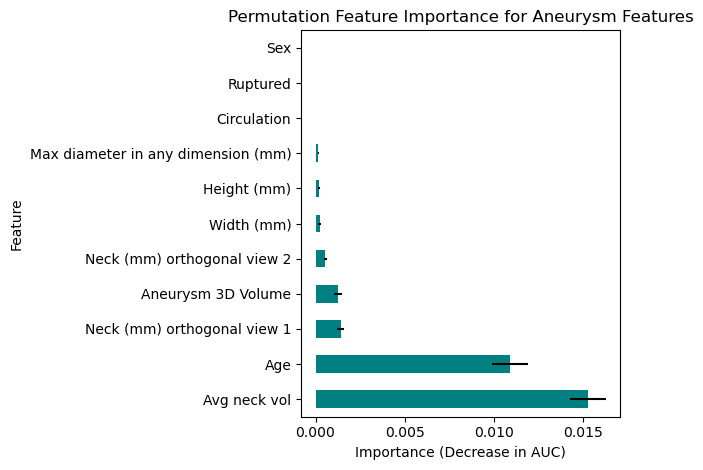

In [38]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# List of procedural features
aneurysm_features = [
'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2', 'Avg neck vol',
    'Aneurysm 3D Volume', 'Age', 'Sex']

# Perform permutation importance on the whole dataset but focus on procedural features
perm_importance = permutation_importance(
    model,  # Trained RandomForest model
    X,  # Full feature set to ensure feature name consistency
    y,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc_ovr'
)

# Filter results for procedural features
procedural_importance = {
    feature: perm_importance.importances_mean[X.columns.get_loc(feature)]
    for feature in aneurysm_features
}

# Convert results into a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': procedural_importance.keys(),
    'Importance': procedural_importance.values(),
    'Std': [perm_importance.importances_std[X.columns.get_loc(f)] for f in aneurysm_features]
}).sort_values(by='Importance', ascending=False)

# Display the importance DataFrame
print(importance_df)

# Plot Permutation Importance
importance_df.plot.barh(
    x='Feature', y='Importance', xerr='Std', legend=False, color='teal'
)
plt.title("Permutation Feature Importance for Aneurysm Features")
plt.xlabel("Importance (Decrease in AUC)")
plt.tight_layout()
plt.show()


In [39]:
features

['Age',
 'Sex',
 'Ruptured',
 'Circulation',
 'Max diameter in any dimension (mm)',
 'Height (mm)',
 'Width (mm)',
 'Neck (mm) orthogonal view 1',
 'Neck (mm) orthogonal view 2',
 'Avg neck vol',
 'Aneurysm 3D Volume',
 'SL/Elongated',
 'Final WEB Volume',
 'Complete WEB failure/abandonment',
 'Re-sizing required',
 'Stenting used to support WEB?',
 'Composite outcome',
 'Procedure related ischemic stroke?',
 'Intraop rupture']

##
similarity between the synthetic and original datasets based on their Euclidean distances

In [40]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

original_data = original_df[features].dropna()
synthetic_data = synthetic_df[features]

#  Euclidean distances
distances = cdist(synthetic_data, original_data, metric='euclidean')  # Pairwise distances
min_distances = np.min(distances, axis=1)  # Minimum distance for each synthetic point to original

print(f"Mean Euclidean Distance (Synthetic -> Original): {np.mean(min_distances):.4f}")
print(f"Median Euclidean Distance (Synthetic -> Original): {np.median(min_distances):.4f}")
print(f"Min Euclidean Distance (Synthetic -> Original): {np.min(min_distances):.4f}")
print(f"Max Euclidean Distance (Synthetic -> Original): {np.max(min_distances):.4f}")

# ORIGINAL-to-original distances
original_distances = cdist(original_data, original_data, metric='euclidean')
np.fill_diagonal(original_distances, np.inf)  # Ignore self-distances
min_original_distances = np.min(original_distances, axis=1)

print(f"Mean Euclidean Distance (Original -> Original): {np.mean(min_original_distances):.4f}")
print(f"Median Euclidean Distance (Original -> Original): {np.median(min_original_distances):.4f}")
print(f"Min Euclidean Distance (Original -> Original): {np.min(min_original_distances):.4f}")
print(f"Max Euclidean Distance (Original -> Original): {np.max(min_original_distances):.4f}")


Mean Euclidean Distance (Synthetic -> Original): 18.2262
Median Euclidean Distance (Synthetic -> Original): 14.7507
Min Euclidean Distance (Synthetic -> Original): 1.9282
Max Euclidean Distance (Synthetic -> Original): 79.9110
Mean Euclidean Distance (Original -> Original): 23.2178
Median Euclidean Distance (Original -> Original): 14.1407
Min Euclidean Distance (Original -> Original): 3.5302
Max Euclidean Distance (Original -> Original): 113.4804


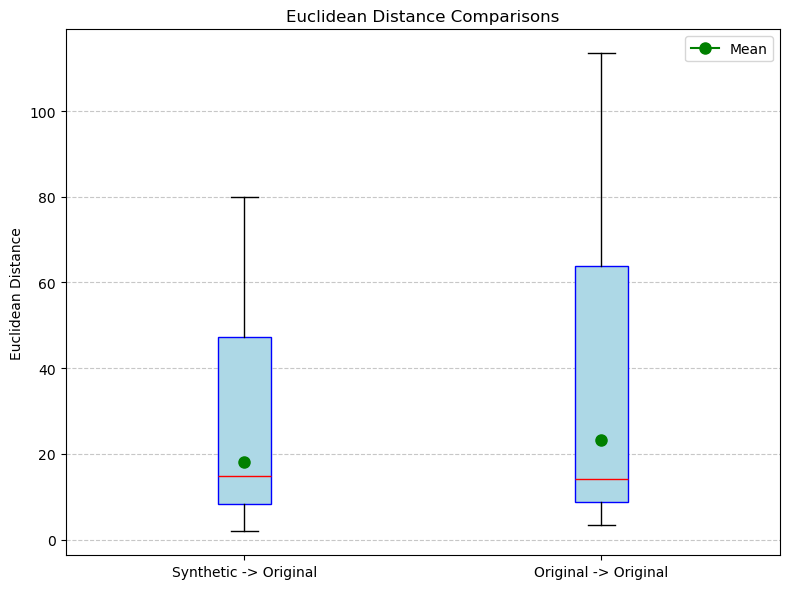

In [41]:
import matplotlib.pyplot as plt

# Data
distances = {
    "Synthetic -> Original": {
        "Mean": 18.2262,
        "Median": 14.7507,
        "Min": 1.9282,
        "Max": 79.9110
    },
    "Original -> Original": {
        "Mean": 23.2178,
        "Median": 14.1407,
        "Min": 3.5302,
        "Max": 113.4804
    }
}

# Prepare data for plotting
box_data = [
    [distances["Synthetic -> Original"]["Min"], 
     distances["Synthetic -> Original"]["Median"], 
     distances["Synthetic -> Original"]["Max"]],
    
    [distances["Original -> Original"]["Min"], 
     distances["Original -> Original"]["Median"], 
     distances["Original -> Original"]["Max"]]
]

means = [
    distances["Synthetic -> Original"]["Mean"], 
    distances["Original -> Original"]["Mean"]
]

# Box plot
fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(box_data, vert=True, patch_artist=True, labels=["Synthetic -> Original", "Original -> Original"], 
                boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'))

# Overlay mean points
for i, mean in enumerate(means):
    ax.plot(i + 1, mean, marker="o", markersize=8, color="green", label="Mean" if i == 0 else "")

# Add legend
ax.legend(loc="upper right")

# Add labels and title
ax.set_title("Euclidean Distance Comparisons")
ax.set_ylabel("Euclidean Distance")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
